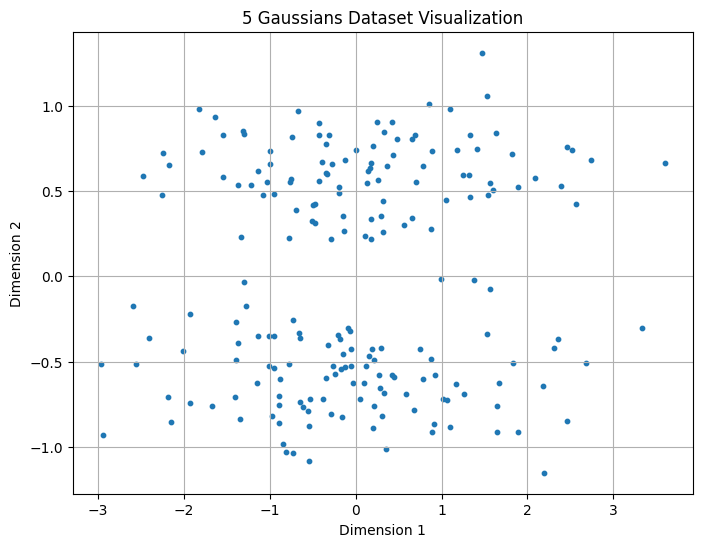

In [8]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load('/Users/yanqingluo/Desktop/LabML/git/problem_set2/data/2_gaussians.npy')
X = X.T
X_mean = np.mean(X)
X_std = np.std(X)
X = (X - X_mean) / X_std
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('5 Gaussians Dataset Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [3]:
def kmeans(X, k, max_iter=100):
    # Include your kmeans implementation here, make sure it matches what you provided earlier
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]
    labels = None
    loss = 0
    for _ in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        loss = np.sum(np.min(distances, axis=1))
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, labels, loss

In [4]:
from scipy.stats import multivariate_normal

def gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3, kmeans_func=None):
    """ Implements EM for Gaussian Mixture Models """
    n, d = X.shape  # Number of samples (n) and dimensions (d)
    
    # Initialize means using kmeans or randomly
    if init_kmeans:
        if kmeans_func is None:
            raise ValueError("kmeans function must be provided for initialization with kmeans")
        _, indices, _ = kmeans_func(X, k, 100)
    else:
        indices = np.random.choice(n, k, replace=False)
    mu = X[indices, :]  # Initial means

    # Initialize covariances to identity matrices
    sigma = [np.eye(d) for _ in range(k)]

    # Initialize weights to be equal
    pi = np.full(k, 1 / k)
    log_likelihood = 0

    def expectation(X, pi, mu, sigma):
        """ Calculate responsibilities (gamma) """
        gamma = np.zeros((n, k))
        for j in range(k):
            pdf = multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X)
            gamma[:, j] = pi[j] * pdf
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma

    def maximization(X, gamma):
        """ Update pi, mu, and sigma """
        Nk = gamma.sum(axis=0)  # Sum responsibilities for each cluster
        pi = Nk / n
        mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]
        sigma = [np.dot((gamma[:, j][:, np.newaxis] * (X - mu[j])).T, X - mu[j]) / Nk[j] for j in range(k)]
        return pi, mu, sigma

    for l in range(max_iter):
        gamma = expectation(X, pi, mu, sigma)
        prev_log_likelihood = log_likelihood
        log_likelihood = np.sum(np.log(np.dot(gamma, pi)))
        pi, mu, sigma = maximization(X, gamma)
        if np.abs(log_likelihood - prev_log_likelihood) < eps:
            break
        print(f"number of iterations: {l+1}, log likelihood: {log_likelihood}")
    
    return pi, mu, sigma, log_likelihood, gamma


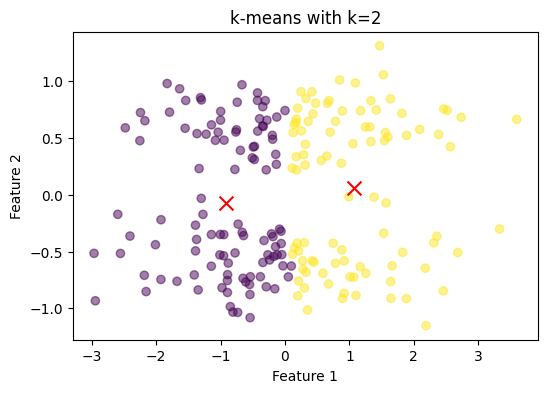

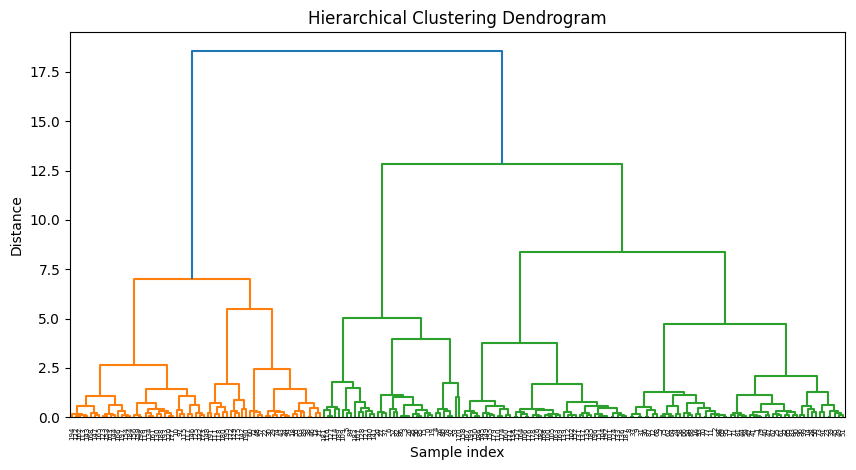

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming 'data' is your dataset and 'custom_kmeans' is your k-means function
centroids, labels, loss = kmeans(X, 2)
results= (centroids, labels)

# Plotting each k-means result
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x')  # mark centroids
plt.title(f'k-means with k=2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

number of iterations: 1, log likelihood: -138.62943611198907


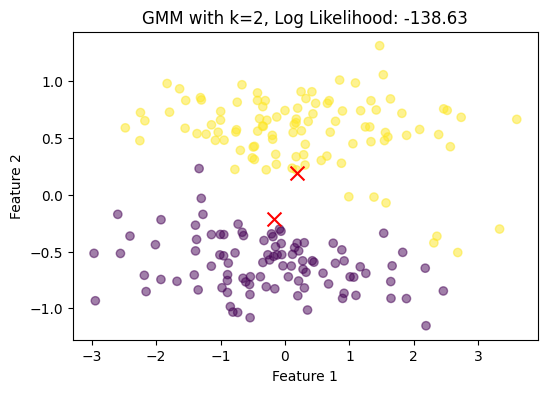

In [7]:
pi, mu, sigma, log_likelihood, gamma = gmm(X, 2, init_kmeans=False, kmeans_func=kmeans)
labels = np.argmax(gamma, axis=1)

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5, cmap='viridis')
plt.scatter(mu[:, 0], mu[:, 1], c='red', s=100, marker='x')  # Mark cluster centers
plt.title(f'GMM with k=2, Log Likelihood: {log_likelihood:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()